In [ ]:
import matplotlib
%matplotlib inline

from sklearn.linear_model    import LogisticRegression
from sklearn.datasets        import make_circles, make_blobs
from sklearn.model_selection import train_test_split
from matplotlib              import pyplot as plt
from sklearn.metrics         import confusion_matrix

import pandas as pd
import numpy as np


# Regresión logística con descenso del gradiente

La función logística ajusta una probabilidad y tiene muchas propiedades como ser continua y derivable. La vamos a ocupar para determinar con qué probabilidad pertenece algún vector $x$ a alguna clase $C_i$ de puntos. Y ese va a ser precisamente nuestro problema, considerando que ya tengo una distribución de puntos agrupados en clases, así cómo la distribución de cada clase, es decir 

$$
Pr(x|C_i)  ;  Pr(C_i)
$$

Cómo entonces puedo determinar la clase dado que tengo un punto nuevo, es decir, poder computar

$$
Pr(C_i|x)
$$

Es decir, nos gustaría construir un **modelo generativo**.

## Sigmoide

Consideren el caso binario, $i \in {1,2}$, y donde queremos saber la probabilidad de ajustar la probabilidad _a posteriori_ de $C_1$ de acuerdo con Bayes

$$
p(C=C_1 | x ) = \frac {p(x|C_1)p(C_1)} {p(x|C_1)p(C_1) + p(x|C_2)p(C_2)}
$$

Si dividimos numerador y denominador de cada término en la expresión anterior por $p(x|C_1)p(C_1)$ obtenemos:

$$
p(C=C_1 | x ) = \frac {1} {1 + \frac {p(x|C_2)p(C_2)} {p(x|C_1)Pr(C_1)}}
$$


Sea $a =  \log \left( \frac {p(x|C_1)p(C_1)} {p(x|C_2)p(C_2)}\right)$ entonces podemos reexpresar la función anterior como:

$$
\sigma (a) = \frac {1} {1 + \exp(-a)}
$$

que es la función *sigmoide*

Que tiene varias propiedades como $\sigma (-a) = 1 - \sigma(a)$ y que su inverso es

$$
a = \log \left ( \frac {\sigma} {1 - \sigma} \right )
$$

que es la razón de las probabilidades $\log \left [ \frac {p(C_1| x)} {p(C_2|x)}  \right]$. Para más de dos clases lo que obtenemos es la *exponencial normalizada* o *softmax*.



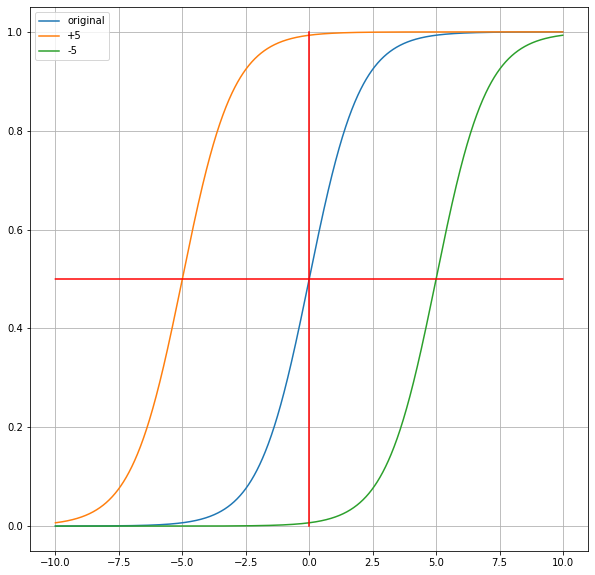

In [ ]:
def sigmoide(x):
    return 1 / (1 + np.exp(-x))

X  = np.arange(-10,10,1/100)
Y  = sigmoide(X)
Y2 = sigmoide(X+5)
Y3 = sigmoide(X-5)

fig = plt.figure(figsize=(10,10))
plt.plot(X,Y, label="original")
plt.plot(X,Y2, label="+5")
plt.plot(X,Y3, label="-5")
plt.plot([0,0], [0.,1], 'r')
plt.plot(X,np.zeros_like(Y)+.5, 'r')
plt.grid()
plt.legend()

Si yo tengo una serie de puntos en $\mathcal{R^n}; n>2$ ¿cómo encuentro el mejor margen que los divide? (¿Cómo puedo ajustar la verosimilitud dada por los datos?) 

Es decir yo quiero maximizar la verosimilitud de un proceso de Bernoulli

$$
\operatorname{p}\left(Y=y_{i} \mid x_{i}\right)=\prod s_{\beta}\left(x_{i}\right)^{y_{i}}\left(1-s_{\beta}\left(x_{i}\right)\right)^{1-y_{i}}
$$

Pero como trabajar con productos es muy difícil, entonces voy a ocupar la función $\log$

$$
\mathcal{L}=\log (\operatorname{p})=\sum y_{i} \log \left(s_{\beta}\left(x_{i}\right)\right)+\left(1-y_{i}\right)\left(\log \left(1-s_{\beta}\left(x_{i}\right)\right)\right)
$$

In [ ]:
X,y = make_blobs(centers=2, n_features=2, n_samples=500, center_box=[(-4,3),(5,-1)],random_state=213)
Xn, Xt, yn, yt = train_test_split(X,y)

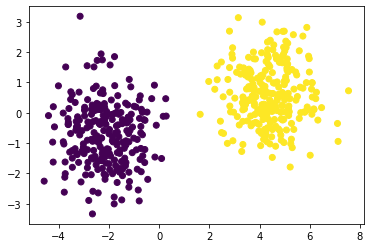

In [ ]:
plt.scatter(X[:,0],X[:,1],c=y)

Una opción para encontrar las $\beta$ que máximas las probabilidades de la sigmoide y por lo tanto de $\mathcal{L}$ es el descenso del gradiente.

$$
\beta(t+1) = \beta(t) - \eta \cdot \nabla J(\beta(t))
$$

Y como función $J$ podemos ocupar a $-\mathcal{L}$

y también podemos ocupar el hecho de que 

$$
s_{\beta}(x_i) ' = s_\beta(x) \cdot (1 - s_\beta(x_i))
$$

Entonces derivando

$$
\begin{aligned}
\frac{\partial J}{\partial \beta_{j}} &=-y_{i} \frac{s_{\beta}\left(x_{i}\right)\left(1-s_{\beta}\left(x_{i}\right)\right)}{s_{\beta}\left(x_{i}\right)} x_{j}-\left(y_{i}-1\right) \frac{s_{\beta}\left(x_{i}\right)\left(1-s_{\beta}\left(x_{i}\right)\right)}{1-s_{\beta}\left(x_{i}\right)} x_{j} \\
\frac{\partial J}{\partial \beta_{j}} &=-\left[y_{i}\left(1-s_{\beta}\left(x_{i}\right)\right)+\left(y_{i}-1\right) s_{\beta}\left(x_{i}\right)\right] x_{j} \\
\frac{\partial J}{\partial \beta_{j}} &=-\left[y_{i}-s_{\beta}\left(x_{i}\right)\right] x_{j} \\
\frac{\partial J}{\partial \beta_{j}} &=\left[s_{\beta}\left(x_{i}\right)-y_{i}\right] x_{j}
\end{aligned}
$$

Haciendo $\Delta \equiv  s_{\beta}\left(x_{i}\right)-y_{i}$ obtengo

$$
\frac{\partial J}{\partial \beta_{j}} = \Delta_i x_j
$$

In [ ]:
def agrega_bias(X):
  """
  Agrega nodo de sesgo w0
  """
  n,d = X.shape
  u = np.ones((n,1))
  return np.hstack((u,X))

def estandariza(X):
  """
  Centra los datos en cero y 
  divide todo por la desviación estandar.
  """
  return (X - X.mean(axis=0)) / X.std(axis=0)

def normaliza(X):
  """"
  Lleva todo al [0,1]
  """
  rg = np.amin(X,axis=0) - np.amax(X,axis=0)
  return (X+X.min(axis=0))/rg

def loglikelihood(H,y,th):
  """
  Computa la log-verosimilitud
  """
  return (-np.dot(y,np.log(H)) - np.dot((1-y),np.log(1-H)))

def score(th,X):
  """
  sigmoide de la proyección del vector X con pesos th
  """
  return sigmoide(np.dot(X,th))

def gradiente(w,X,y):
  """
  Gradiente de <X,w> con 
  target y 
  """
  h = sigmoide(np.dot(X,w))
  z = h.T - y
  gr = np.dot(X.T, z.T)
  return gr
    
def grad_desc(X,y,iters, a=0.01,t=100, tol=1e-3):
  """"
  Descenso del gradiente con constante de aprendizaje a
  de estímulos X con target y
  """
  #gr = lambda w, X, y: dot(X.T, (sigmoide(w.T,X.T) - y).T)
  n, d = X.shape
  w = np.random.ranf((d,1))
  pesos = [w[:]]
  pesos = np.random.ranf((1,d))
  w = pesos[-1]
  h  = sigmoide(np.dot(X,w))
  j  = loglikelihood(h,y,w)
  costos = [j]
  for i in range(iters):
    gr = gradiente(w,X,y)
    w -= a*gr
    pesos  = np.vstack((pesos,w))
    h  = sigmoide(np.dot(X,w))
    j  = loglikelihood(h,y,w)
    costos.append(j)
    if(i%t==0 or j < tol):
      pesos[i] = w
      print('{0}:{1}'.format(i,j))
      #print("peso {}".format(w))
    if(j<tol):
      break
  return w, pesos, costos


Xs = normaliza(X)
#plt.scatter(Xs[:,0],Xs[:,1],c=y)
Xb = agrega_bias(Xs)
Xt, Xp, yt, yp = train_test_split(Xb, y)
wf, W, J = grad_desc(Xt,yt,30000,0.05, t=1000)


0:1090.201576332692
1000:1.3427420451692729
2000:0.8718680511251711
3000:0.6740981983311869
4000:0.5599459820595742
5000:0.48383747318746995
6000:0.4286871732549885
7000:0.38648928466596577
8000:0.3529384193948114
9000:0.32548997358232623
10000:0.3025325615541379
11000:0.2829904851811508
12000:0.2661150839681634
13000:0.2513674005906852
14000:0.23834844238414304
15000:0.22675580397114398
16000:0.2163556404851795
17000:0.20696396432696015
18000:0.1984338119338483
19000:0.19064622270580905
20000:0.1835037615876427
21000:0.17692577983958735
22000:0.17084488897486536
23000:0.16520429758034022
24000:0.15995577239311232
25000:0.15505805798800404
26000:0.15047563811911646
27000:0.1461777548475656
28000:0.14213762445779282
29000:0.13833180521919747


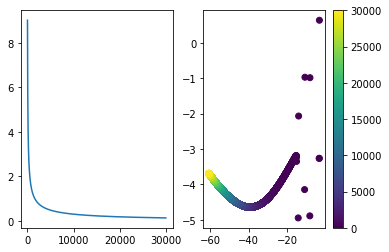

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(J[20:])
im = ax2.scatter(W[:,1], W[:,2], c=range(len(W)))
fig.colorbar(im,ax=ax2)

In [ ]:
h = sigmoide(np.dot(Xp,wf))
S = 0
for vv,vp in zip(h,yp):
    S += (vv-vp)**2
print("Erorr {0}".format(S/2))

print(confusion_matrix(np.round(h),yp))

Erorr 1.2131325264842827e-06
[[64  0]
 [ 0 61]]


In [ ]:
for vv,vp in zip(h,yp):
    print("{0} : {1}".format(np.round(vv),vp))

1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
1.0 : 1
0.0 : 0
1.0 : 1
1.0 : 1
1.0 : 1
1.0 : 1
1.0 : 1
0.0 : 0
1.0 : 1
0.0 : 0
1.0 : 1
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
1.0 : 1
0.0 : 0
1.0 : 1
1.0 : 1
1.0 : 1
1.0 : 1
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
1.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
1.0 : 1
1.0 : 1
1.0 : 1
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
1.0 : 1
0.0 : 0
1.0 : 1
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
1.0 : 1
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
1.0 : 1
1.0 : 1
1.0 : 1
1.0 : 1
1.0 : 1
1.0 : 1
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
1.0 : 1
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
1.0 : 1
1.0 : 1
1.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
1.0 : 1
0.0 : 0
1.0 : 1
1.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
0.0 : 0
1.0 : 1
0.0 : 0
0.0 : 0
0.0 : 0
1.0 : 1
1.0 : 1


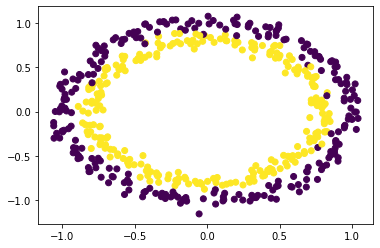

In [ ]:
C,c = make_circles(500, noise=0.05, random_state=1234) 

plt.scatter(C[:,0],C[:,1],c=c)

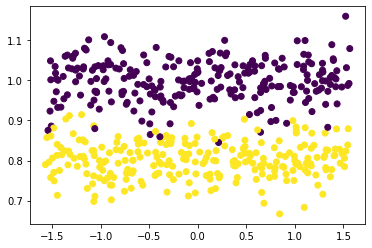

In [ ]:
Xu = np.zeros_like(C)
Xu[:,0], Xu[:,1] = np.arctan(C[:,1]/C[:,0]), np.linalg.norm(C,axis=1)
plt.scatter(Xu[:,0], Xu[:,1], c=c)

In [ ]:
Xu = agrega_bias(Xu)
Ct, Cp, ct, cp = train_test_split(Xu, c)
wf, W, J = grad_desc(Ct,ct,30000,0.05)


0:1485.8460717978737
100:497.1673277532012
200:30.419899265139183
300:30.044686126692866
400:29.723266400598863
500:29.44513142042437
600:29.20234732830089
700:28.9888086399108
800:28.799738147632254
900:28.631343016518166
1000:28.48057282770121
1100:28.34494587888279
1200:28.222422227298097
1300:28.1113093923144
1400:28.01019129359777
1500:27.9178739918545
1600:27.83334376128842
1700:27.755734335419938
1800:27.68430106159059
1900:27.618400317934075
2000:27.557472981014378
2100:27.501031041693857
2200:27.448646689913062
2300:27.3999433518861
2400:27.354588283340757
2500:27.312286411968
2600:27.27277518961573
2700:27.23582026591235
2800:27.20121183416478
2900:27.168761530592484
3000:27.13829979145106
3100:27.109673590987136
3200:27.08274449765993
3300:27.05738699755544
3400:27.033487043088748
3500:27.01094079244289
3600:26.98965351112595
3700:26.96953861183659
3800:26.950516812745406
3900:26.932515397506812
4000:26.91546756295056
4100:26.899311842579344
4200:26.883991595801447
4300:26.8

In [ ]:
h = sigmoide(np.dot(Cp,wf))

S = 0
for vv,vp in zip(h,cp):
    S += (vv-vp)**2
print("Erorr {0}".format(S/2))

print(confusion_matrix(np.round(h), cp))



Erorr 0.8852827644204257
[[55  1]
 [ 1 68]]


In [ ]:
print(wf)

[ 6.76758843e+01  6.67757010e-04 -7.60373839e+01]


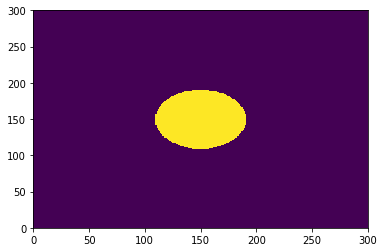

In [ ]:
P = np.arange(-1.5,1.5,0.01)
Q = np.arange(-1.5,1.5,0.01)
Z = np.zeros((len(P),len(Q)))

def trans(p,q):
    try:
      coor_pol = np.array( [1,np.arctan(q/p),np.linalg.norm( np.array([p,q]) )] )
      return coor_pol 
    except:
        if(p==0):
            return np.array( [1,0,0] )
        
for p in range(len(P)):
    for q in range(len(Q)):
        x,y = P[p], Q[q]
        cpl = trans(x,y)
        z = np.dot(cpl,wf)
        Z[p,q] = np.round(int(sigmoide( z )))
plt.pcolor(Z)